In [ ]:
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
%env LLM_API_KEY=sk-替换为自己的Qwen API_KEY

In [2]:
%%capture --no-stderr
!pip install -U langchain langchain_community langchain_openai pypdf sentence_transformers chromadb shutil

In [3]:
import os
import pandas as pd

In [4]:
expr_version = 'split_01_1_markdown_text_split'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

os.makedirs(expr_dir, exist_ok=True)

# 读取文档

In [5]:
markdown_document = open(os.path.join(os.path.pardir, 'outputs', 'MinerU_parsed_20241204', '2024全球经济金融展望报告.md')).read()
qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))

# 文档切分

In [6]:
import os
from langchain.text_splitter import MarkdownTextSplitter
from langchain.schema import Document

def split_docs(markdown_document, chunk_size=500, chunk_overlap=50):
    splitter = MarkdownTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    splitted_texts = splitter.split_text(markdown_document)
    return [Document(page_content=text) for text in splitted_texts]

In [7]:
splitted_docs = split_docs(markdown_document)
print(len(splitted_docs))

92


In [8]:
splitted_docs[:3]

[Document(metadata={}, page_content='# 全球经济金融展望报告  \n\n2024年年报（总第57期）  \n\n报告日期：2023年12月12日  \n\n# 要点  \n\n●2023 年全球经济增长动力持续回落，各国复苏分化，发达经济体增速明显放缓，新兴经济体整体表现稳定。全球贸易增长乏力，各国生产景气度逐渐回落，内需对经济的拉动作用减弱。欧美央行货币政策紧缩态势放缓，美元指数高位震荡后走弱，全球股市表现总体好于预期，但区域分化明显。高利率环境抑制债券融资需求，债券违约风险持续上升。  \n\n$\\bullet$ 展望2024 年，预计全球经济复苏将依旧疲软，主要经济体增长态势和货币政策走势将进一步分化。欧美央行大概率结束本轮紧缩货币周期，美元指数将逐步走弱，流向新兴经济体的跨境资本将增加。国际原油市场短缺格局或延续，新能源发展成为重点。  \n\n$\\bullet$ 海湾六国经济发展与投资前景、高利率和高债务对美国房地产市场脆弱性的影响等热点问题值得关注。'),
 Document(metadata={}, page_content='![](images/c7e6ce1606712e84e07a05bcf6016906efa3fc778e40fcd0e91ac4fcb5503b79.jpg)  \n主要经济体GDP 增速变化趋势（%）  \n资料来源：IMF，中国银行研究院  \n\n# 中国银行研究院全球经济金融研究课题组  \n\n![](images/a5d0eb181c75231451c8f890ec50fe5822e2306a9beb543ca35a04880abbf639.jpg)  \n\n联系人：王有鑫  \n电话：010-66594127  \n邮件： wangyouxin_hq@bank-of-china.com  \n\n# 全球经济复苏疲软，货币政策取向分化  \n\n——中国银行全球经济金融展望报告（2024年）'),
 Document(metadata={}, page_content='2023年，全球经济增长动力持续回落。分区域看，各国复苏存在较大差异，发达经济体增速明显放缓，新兴经济体增速与2022年大致持平。生产端，全球供应链持续恢复，但生产景气度逐渐回落。需求端，内需对经济的拉

检查一下切分后的块长度分布

In [9]:
pd.Series([len(d.page_content) for d in splitted_docs]).describe()

count     92.000000
mean     376.663043
std      116.359171
min       43.000000
25%      328.750000
50%      408.000000
75%      466.250000
max      499.000000
dtype: float64

# 检索

In [10]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Chroma
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='为这个句子生成表示以用于检索相关文章：'
    )
    return embeddings

device: cuda


In [11]:
import shutil

from tqdm.auto import tqdm
from langchain_community.vectorstores import Chroma

model_path = 'BAAI/bge-large-zh-v1.5'
embeddings = get_embeddings(model_path)

persist_directory = os.path.join(expr_dir, 'chroma', 'bge')
shutil.rmtree(persist_directory, ignore_errors=True)
vector_db = Chroma.from_documents(
    splitted_docs,
    embedding=embeddings,
    persist_directory=persist_directory
)

# 生成答案

In [12]:
from langchain.llms import Ollama

ollama_llm = Ollama(
    model='qwen2:7b-instruct-32k',
    # model='qwen2:7b-instruct',
    base_url='http://localhost:11434',
    top_k=1
)

/tmp/ipykernel_511720/432419542.py:3: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  ollama_llm = Ollama(


In [13]:
import time

def rag(llm, query, n_chunks=4):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{query}}
请回答：
""".strip()
    chunks = vector_db.similarity_search(query, k=n_chunks)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{query}}', query)
    retry_count = 3

    resp = ''
    while retry_count > 0:
        try:
            resp = llm.invoke(prompt)
            break
        except Exception as e:
            retry_count -= 1
            sleeping_seconds = 2 ** (4 - retry_count)
            print(f"query={query}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
            
            time.sleep(sleeping_seconds)
    
    return resp, chunks

## 预测

In [14]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

def predict(llm, prediction_df, n_chunks):
    prediction_df = prediction_df.copy()
    answer_dict = {}

    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        uuid = row['uuid']
        question = row['question']
        answer, chunks = rag(llm, question, n_chunks=n_chunks)
        assert len(chunks) <= n_chunks
        answer_dict[question] = {
            'uuid': uuid,
            'ref_answer': row['ref_answer'],
            'gen_answer': answer,
            'chunks': chunks
        }

    prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
    prediction_df.loc[:, 'chunks'] = prediction_df['question'].apply(lambda q: answer_dict[q]['chunks'])

    return prediction_df

In [15]:
pred_df = predict(ollama_llm, prediction_df, n_chunks=3)

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
save_path = os.path.join(expr_dir, 'predictions.xlsx')
pred_df.to_excel(save_path, index=False)

# 评估

In [17]:
from langchain_openai import ChatOpenAI
import time

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in prediction_df.iterrows():
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        
        retry_count = 3
        result = ''
        
        while retry_count > 0:
            try:
                result = judge_llm.invoke(prompt).content
                break
            except Exception as e:
                retry_count -= 1
                sleeping_seconds = 2 ** (4 - retry_count)
                print(f"query={query}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
                
                time.sleep(sleeping_seconds)
        
        results.append(result)

        time.sleep(1)
    return results

In [18]:
pred_df['raw_score'] = evaluate(pred_df)

In [19]:
pred_df['raw_score'].unique()

array(['是', '否'], dtype=object)

In [20]:
pred_df['score'] = (pred_df['raw_score'] == '是').astype(int)

In [21]:
pred_df['score'].mean()

0.72

In [22]:
save_path = os.path.join(expr_dir, 'eval_df.xlsx')
pred_df.to_excel(save_path, index=False)

# 结果分析

In [23]:
pred_df['avg_chunk_len'] = pred_df['chunks'].apply(lambda chunks: sum([len(d.page_content) for d in chunks]) / len(chunks))
pred_df['max_chunk_len'] = pred_df['chunks'].apply(lambda chunks: max([len(d.page_content) for d in chunks]))

In [24]:
import seaborn as sns

从平均上下文长度来看，回答错误的问题对应的上下文，方差更大

<Axes: xlabel='score', ylabel='avg_chunk_len'>

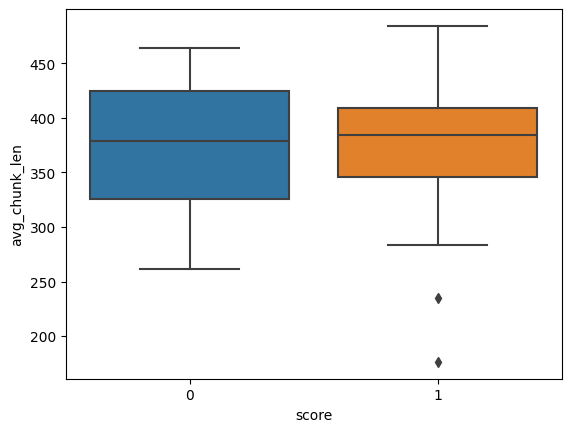

In [25]:
sns.boxplot(x='score', y='avg_chunk_len', data=pred_df)

<Axes: xlabel='score', ylabel='max_chunk_len'>

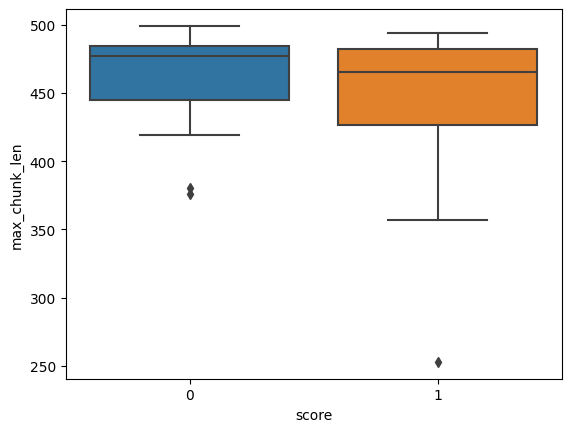

In [26]:
sns.boxplot(x='score', y='max_chunk_len', data=pred_df)